# Loading packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

# Loading Data

In [9]:
matches = pd.read_csv('players.csv')
matches.head()

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,180,37,73,56,108,0,16,0,8840.0,5440.0,NaN,83.0,50.0,-957.0,NaN,NaN,212.0,3120.0,5145.0,1087.0,400.0,NaN,NaN,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,NaN,188.0,16.0,NaN,NaN,NaN,2.0,35.0,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,NaN,NaN,1650.0,3299.0,6676.0,4317.0,937.0,NaN,NaN,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,NaN,346.0,22.0,NaN,NaN,12.0,52.0,30.0,4.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,48,60,59,108,65,0,17,0,6692.0,8112.0,NaN,453.0,259.0,-1436.0,-1015.0,NaN,NaN,3142.0,2418.0,3697.0,400.0,NaN,NaN,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,NaN,643.0,17.0,5.0,NaN,7.0,8.0,28.0,NaN,1.0,18.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,NaN,NaN,938.0,4714.0,4104.0,10432.0,400.0,NaN,NaN,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,NaN,150.0,21.0,NaN,NaN,1.0,9.0,45.0,7.0,NaN,14.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,NaN,62.0,NaN,-1437.0,-1056.0,NaN,4194.0,3217.0,7467.0,9220.0,400.0,NaN,NaN,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,NaN,111.0,23.0,1.0,NaN,NaN,2.0,44.0,6.0,NaN,13.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
matches = matches[['match_id','hero_id','player_slot']]
matches.head(11)

,match_id,hero_id,player_slot
0,0,86,0
1,0,51,1
2,0,83,2
3,0,11,3
4,0,67,4
5,0,106,128
6,0,102,129
7,0,46,130
8,0,7,131
9,0,73,132


In [11]:
matches_result = pd.read_csv('match.csv')
matches_result.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


In [12]:
matches_result = matches_result[['match_id','duration','radiant_win']]
matches_result.head()

,match_id,duration,radiant_win
0,0,2375,True
1,1,2582,False
2,2,2716,False
3,3,3085,False
4,4,1887,True


In [13]:
heroes = pd.read_csv('hero_names.csv')
heroes.head()

,name,hero_id,localized_name
0,npc_dota_hero_antimage,1,Anti-Mage
1,npc_dota_hero_axe,2,Axe
2,npc_dota_hero_bane,3,Bane
3,npc_dota_hero_bloodseeker,4,Bloodseeker
4,npc_dota_hero_crystal_maiden,5,Crystal Maiden


# Processing Data

matches = ['match_id' 'hero_id' 'player_slot']

matches_result = ['match_id','duration','radiant_win']

heroes = ['name','hero_id','localized_name']

In [14]:
u_m_ids = np.unique(matches_result['match_id'])
u_m_ids.shape

(50000,)

In [15]:
u_h_ids = np.unique(heroes['hero_id'])
u_h_ids.shape

(112,)

In [16]:
X = np.zeros(shape=(2*u_m_ids.shape[0],u_h_ids.shape[0]))
row_count = 0
heroid_indid = {}
ind = -1
for index, row in matches.iterrows():
    row = row.values
    m_id, h_id, pslot = row
    m_id = 2*m_id
    if pslot > 4:
        m_id += 1
    if h_id in u_h_ids:
        if h_id not in heroid_indid:
            ind += 1
            heroid_indid[h_id] = ind
        X[m_id,heroid_indid[h_id]] = 1

In [17]:
old_y = matches_result[['duration']].values
y_dur = np.repeat(old_y,2,axis=0)
y_dur.shape

(100000, 1)

In [18]:
old_y = matches_result[['radiant_win']].values
y_win = 1*np.concatenate([old_y, np.invert(old_y)],axis=1).reshape(-1,1)
y_win.shape

(100000, 1)

In [19]:
# remove empty columns
ind = np.arange(X.shape[1])[(np.sum(X,axis=0)==0).ravel()]
X = np.delete(X, ind, 1)

In [20]:
# row sum different of five
ind = np.arange(X.shape[0])[(np.sum(X,axis=1)!=5).ravel()]
X = np.delete(X, ind, 0)
y_dur = np.delete(y_dur, ind, 0)
y_win = np.delete(y_win, ind, 0)
X.shape

(99964, 110)

In [21]:
indid_heroid = {heroid_indid[i]:i for i in heroid_indid}
heroid_name = {heroes.iloc[i,1]:heroes.iloc[i,2] for i in range(heroes.values.shape[0])}

In [22]:
indid_heroname = {i:heroid_name[indid_heroid[i]] for i in indid_heroid}

# Exploratory Data Analysis

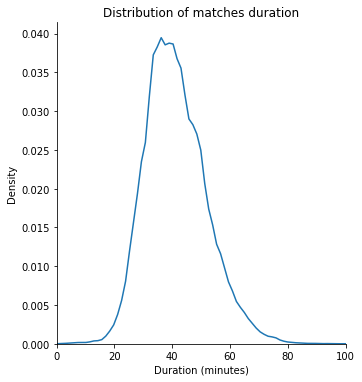

In [23]:
ax = sns.displot(data=y_dur/60, kind="kde", legend=False)
ax.set(xlabel='Duration (minutes)', ylabel = 'Density',
       title = 'Distribution of matches duration',
       xlim = (0,100))
plt.savefig('gdrive/MyDrive/dadosML/images/eda1.png',bbox_inches='tight')

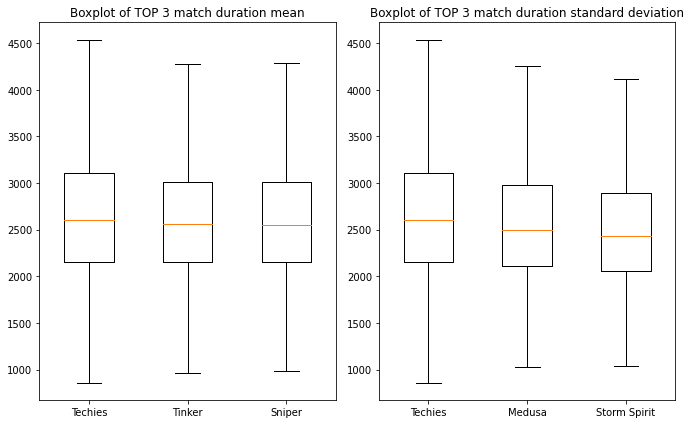

In [25]:
df_stats = {'mean':[], 'std':[]}
for i in range(X.shape[1]):
    y_i = y_dur[X[:,i]==1]
    df_stats['mean'].append(np.mean(y_i))
    df_stats['std'].append(np.std(y_i))
df_stats = pd.DataFrame(df_stats)

df_stats = df_stats.sort_values(by=['mean'], ascending=False)
topmean = df_stats.index[0:3].values
df_stats = df_stats.sort_values(by=['std'], ascending=False)
topstd = df_stats.index[0:3].values

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
for i in range(3):
    ax[0].boxplot(y_dur[X[:,topmean[i]]==1], positions=[i], sym='', widths=0.5)
    ax[1].boxplot(y_dur[X[:,topstd[i]]==1], positions=[i], sym='', widths=0.5)
ax[0].set_xticklabels([indid_heroname[i] for i in topmean])
ax[1].set_xticklabels([indid_heroname[i] for i in topstd])
ax[0].set_title('Boxplot of TOP 3 match duration mean')
ax[1].set_title('Boxplot of TOP 3 match duration standard deviation')
plt.tight_layout()
plt.savefig('gdrive/MyDrive/dadosML/images/eda2.png',bbox_inches='tight')

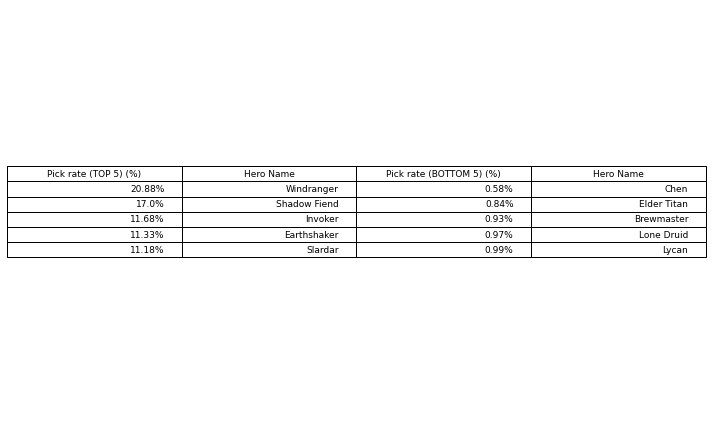

In [26]:
heropicks = np.sum(X, axis=0)/X.shape[0]*100
pickrates_heroes = pd.DataFrame({'pickrate':heropicks,
                                'hero_name':[indid_heroname[i] for i in range(heropicks.shape[0])]})

pickrates_heroes = pickrates_heroes.sort_values(by=['pickrate'], ascending=False)
top = pickrates_heroes[0:5]
pickrates_heroes = pickrates_heroes.sort_values(by=['pickrate'], ascending=True)
bot = pickrates_heroes[0:5]

def stringify(x):
    return str(round(x,2)) + '%'

top['pickrate'] = top['pickrate'].apply(stringify)
bot['pickrate'] = bot['pickrate'].apply(stringify)
top = top.reset_index(drop=True)
bot = bot.reset_index(drop=True)
pickrate = pd.concat([top,bot],axis=1)
pickrate.columns = ['Pick rate (TOP 5) (%)','Hero Name','Pick rate (BOTTOM 5) (%)','Hero Name']

fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=pickrate.values, colLabels=pickrate.columns, loc='center')
fig.tight_layout()
plt.savefig('gdrive/MyDrive/dadosML/images/eda3.png',bbox_inches='tight')
plt.show()

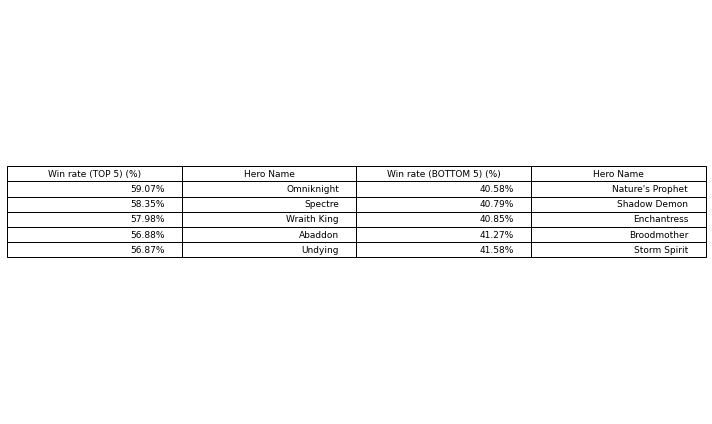

In [27]:
winrate = {i:np.mean(y_win[X[:,i]==1]) for i in range(X.shape[1])}
winrates_heroes = pd.DataFrame({'winrate':[100*winrate[i] for i in range(X.shape[1])],
                                'hero_name':[indid_heroname[i] for i in range(X.shape[1])]})

winrates_heroes = winrates_heroes.sort_values(by=['winrate'], ascending=False)
top = winrates_heroes[0:5]
winrates_heroes = winrates_heroes.sort_values(by=['winrate'], ascending=True)
bot = winrates_heroes[0:5]

top['winrate'] = top['winrate'].apply(stringify)
bot['winrate'] = bot['winrate'].apply(stringify)
top = top.reset_index(drop=True)
bot = bot.reset_index(drop=True)

winrate = pd.concat([top,bot],axis=1)
winrate.columns = ['Win rate (TOP 5) (%)','Hero Name','Win rate (BOTTOM 5) (%)','Hero Name']

fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=winrate.values, colLabels=winrate.columns, loc='center')
fig.tight_layout()
plt.savefig('gdrive/MyDrive/dadosML/images/eda4.png',bbox_inches='tight')
plt.show()

# Models

In [28]:
X_train, X_test, y_train_dur, y_test_dur = train_test_split(X, y_dur, test_size=0.3, random_state=0)
_, _, y_train_win, y_test_win = train_test_split(X, y_win, test_size=0.3, random_state=0)

In [29]:
print(X_train.shape)
print(X_test.shape)

(69974, 110)
(29990, 110)


## Match Duration

In [30]:
def plotResiduals(y_test, y_pred, title):
    res = (y_test-y_pred)/60
    ax = sns.displot(data=res, kind="kde", legend=False)
    ax.set(xlabel='Duration (minutes)', ylabel = 'Density',
           title = 'Residuals '+title,
           xlim = (np.quantile(res,0.01),np.quantile(res,0.99)))

Train R2: 0.032236699676652214
Test R2: 0.031450528217418006


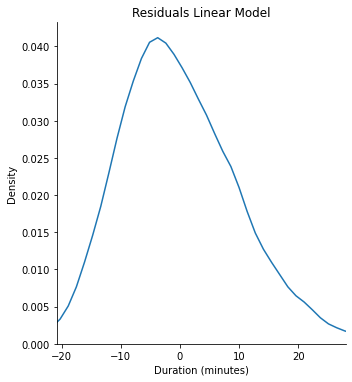

In [35]:
# Linear Regression
lm_dur = LinearRegression().fit(X_train, y_train_dur)
y_pred_lm_dur = lm_dur.predict(X_test)
print('Train R2:',r2_score(y_train_dur, lm_dur.predict(X_train)))
print('Test R2:',r2_score(y_test_dur, y_pred_lm_dur))
plotResiduals(y_test_dur, y_pred_lm_dur, 'Linear Model')

Train R2: 0.032237088972990824
Test R2: 0.03144774994009125


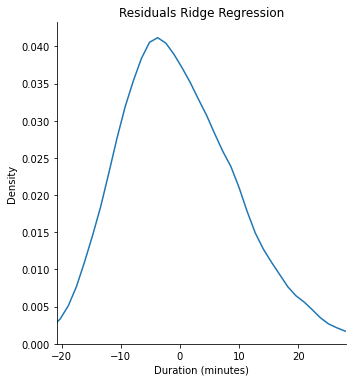

In [43]:
# Ridge Regression 
rr_dur = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train_dur)
y_pred_rr_dur = rr_dur.predict(X_test)
print('Train R2:',r2_score(y_train_dur, rr_dur.predict(X_train)))
print('Test R2:',r2_score(y_test_dur, y_pred_rr_dur))
plotResiduals(y_test_dur, y_pred_rr_dur, 'Ridge Regression')

Chosen depth, minimum samples split, minimum samples leaf: [20, 50, 80]
Train CV mean R2: 0.011462118670884092
Test R2: 0.008528669010268497


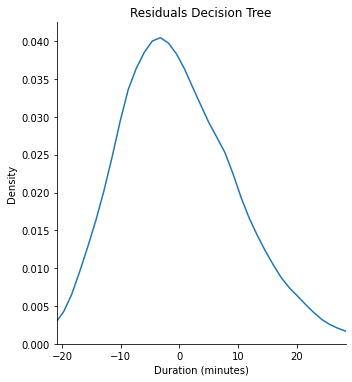

In [44]:
# Decision Tree Regression 
max_depth = [1, 5, 10, 20, 50, 100]
min_samples_split = [50, 100, 200, 400]
min_samples_leaf = [10, 20, 40, 80]
max_score = 0
for md_i, mss_i, msl_i in itertools.product(max_depth, min_samples_split, min_samples_leaf):
  dt_dur_i = DecisionTreeRegressor(max_depth=md_i, min_samples_split=mss_i, min_samples_leaf=msl_i)
  scores_i = cross_val_score(dt_dur_i, X_train, y_train_dur, cv=5)
  if np.mean(scores_i) > max_score:
    dt_dur = dt_dur_i
    max_score = np.mean(scores_i)
    pars = [md_i, mss_i, msl_i]
print('Chosen depth, minimum samples split, minimum samples leaf:', pars)
dt_dur = dt_dur.fit(X_train, y_train_dur)
y_pred_dt_dur = dt_dur.predict(X_test).reshape(-1,1)
print('Train CV mean R2:', max_score)
print('Test R2:',r2_score(y_test_dur, y_pred_dt_dur))
plotResiduals(y_test_dur, y_pred_dt_dur, 'Decision Tree')

Chosen number of estimators, depth, minimum samples split: [50, 100, 400]
Train CV mean R2: 0.020575912972264
Test R2: 0.021342447583959978


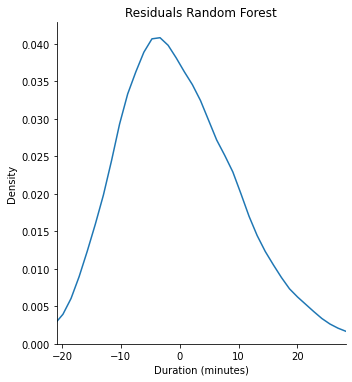

In [46]:
# Random Forest Regression 
n_estimators = [1, 10, 50]
max_depth = [1, 5, 10, 20, 50, 100]
min_samples_split = [50, 100, 200, 400]
max_score = 0
for n_i, md_i, mss_i in itertools.product(n_estimators, max_depth, min_samples_split):
  rf_dur_i = RandomForestRegressor(n_estimators=n_i, max_depth=md_i, min_samples_split=mss_i, min_samples_leaf=40, random_state=0)
  scores_i = cross_val_score(rf_dur_i, X_train, y_train_dur, cv=5)
  if np.mean(scores_i) > max_score:
    rf_dur = rf_dur_i
    max_score = np.mean(scores_i)
    pars = [n_i, md_i, mss_i]
print('Chosen number of estimators, depth, minimum samples split:', pars)
rf_dur = rf_dur.fit(X_train, y_train_dur)
y_pred_rf_dur = rf_dur.predict(X_test).reshape(-1,1)
print('Train CV mean R2:', max_score)
print('Test R2:',r2_score(y_test_dur, y_pred_rf_dur))
plotResiduals(y_test_dur, y_pred_rf_dur, 'Random Forest')

## Win

In [47]:
def plotConfusion(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['label 0','label 1'])
    cmd.plot()
    plt.title('Confusion Matrix for '+title)

Train accuracy: 0.5010575356561008
Test accuracy: 0.49713237745915306


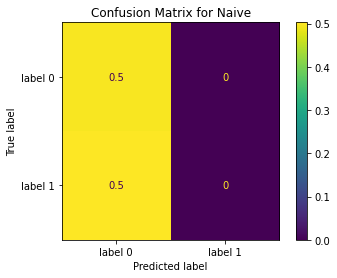

In [53]:
# Naive 
classes, counts = np.unique(y_train_win, return_counts = True)
y_pred_naive_win = np.ones(shape=y_test_win.shape) * classes[np.argmax(counts)]
print('Train accuracy:', accuracy_score(y_train_win, np.ones(shape=y_train_win.shape) * classes[np.argmax(counts)]))
print('Test accuracy:', accuracy_score(y_test_win, y_pred_naive_win))
plotConfusion(y_test_win, y_pred_naive_win, 'Naive')

Train accuracy: 0.5743133163746534
Test accuracy: 0.5704901633877959


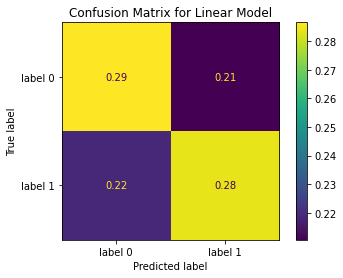

In [54]:
# Linear Regression 
lm_win = LinearRegression().fit(X_train, y_train_win)
y_pred_lm_win = lm_win.predict(X_test) > 0.5
print('Train accuracy:', accuracy_score(y_train_win, lm_win.predict(X_train) > 0.5))
print('Test accuracy:',accuracy_score(y_test_win, y_pred_lm_win))
plotConfusion(y_test_win, y_pred_lm_win, 'Linear Model')

Chosen C: 0.01
Train CV mean accuracy: 0.5728985050143727
Test accuracy: 0.5710570190063354


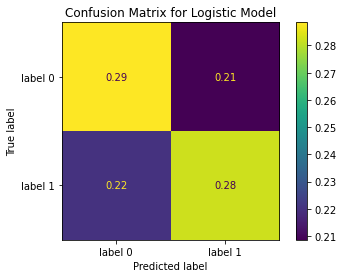

In [56]:
# Logistic Regression  
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_score = 0
for C_i in C:
  lr_win_i = LogisticRegression(C=C_i, random_state=0, solver='lbfgs')
  scores_i = cross_val_score(lr_win_i, X_train, y_train_win, cv=5)
  if np.mean(scores_i) > max_score:
    lr_win = lr_win_i
    max_score = np.mean(scores_i)
    pars = C_i
print('Chosen C:', pars)
lr_win = lr_win.fit(X_train, y_train_win)
y_pred_lr_win = lr_win.predict(X_test).reshape(-1,1) > 0.5
print('Train CV mean accuracy:', max_score)
print('Test accuracy:',accuracy_score(y_test_win, y_pred_lr_win))
plotConfusion(y_test_win, y_pred_lr_win, 'Logistic Model')

Chosen depth, minimum samples split, minimum samples leaf: [20, 50, 40]
Train CV mean accuracy: 0.551176140767316
Test accuracy: 0.5512170723574524


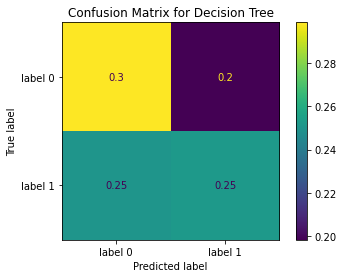

In [57]:
# Decision Tree 
max_depth = [1, 5, 10, 20, 50, 100]
min_samples_split = [50, 100, 200, 400]
min_samples_leaf = [10, 20, 40, 80]
max_score = 0
for md_i, mss_i, msl_i in itertools.product(max_depth, min_samples_split, min_samples_leaf):
  dt_win_i = DecisionTreeClassifier(max_depth=md_i, min_samples_split=mss_i, min_samples_leaf=msl_i)
  scores_i = cross_val_score(dt_win_i, X_train, y_train_win, cv=5)
  if np.mean(scores_i) > max_score:
    dt_win = dt_win_i
    max_score = np.mean(scores_i)
    pars = [md_i, mss_i, msl_i]
print('Chosen depth, minimum samples split, minimum samples leaf:', pars)
dt_win = dt_win.fit(X_train, y_train_win)
y_pred_dt_win = dt_win.predict(X_test).reshape(-1,1)
print('Train CV mean accuracy:', max_score)
print('Test accuracy:',accuracy_score(y_test_win, y_pred_dt_win))
plotConfusion(y_test_win, y_pred_dt_win, 'Decision Tree')

Chosen number of estimators: 200
Train CV mean accuracy: 0.5601509277466589
Test accuracy: 0.5604534844948316


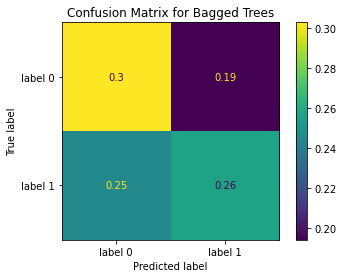

In [58]:
# Bagged Trees 
n_estimators = [1, 10, 50, 100, 200]
max_score = 0
for n_i in n_estimators:
  bt_win_i = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20, min_samples_split=200, min_samples_leaf=40),
                               n_estimators=n_i, random_state=0)
  scores_i = cross_val_score(bt_win_i, X_train, y_train_win, cv=5)
  if np.mean(scores_i) > max_score:
    bt_win = bt_win_i
    max_score = np.mean(scores_i)
    pars = n_i
print('Chosen number of estimators:', n_i)
bt_win = bt_win.fit(X_train, y_train_win)
y_pred_bt_win = bt_win.predict(X_test).reshape(-1,1)
print('Train CV mean accuracy:', max_score)
print('Test accuracy:',accuracy_score(y_test_win, y_pred_bt_win))
plotConfusion(y_test_win, y_pred_bt_win, 'Bagged Trees')

Chosen number of estimators, depth, minimum samples split: [50, 50, 200]
Train CV mean accuracy: 0.5676251328658538
Test accuracy: 0.5664888296098699


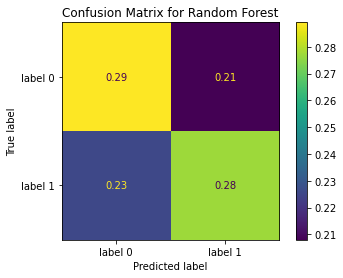

In [60]:
# Random Forest 
n_estimators = [1, 10, 50, 100]
max_depth = [1, 5, 10, 20, 50, 100]
min_samples_split = [50, 100, 200, 400]
max_score = 0
for n_i, md_i, mss_i in itertools.product(n_estimators, max_depth, min_samples_split):
  rf_win_i = RandomForestClassifier(n_estimators=n_i, max_depth=md_i, min_samples_split=mss_i, min_samples_leaf=40, random_state=0)
  scores_i = cross_val_score(rf_win_i, X_train, y_train_win, cv=5)
  if np.mean(scores_i) > max_score:
    rf_win = rf_win_i
    max_score = np.mean(scores_i)
    pars = [n_i, md_i, mss_i]
print('Chosen number of estimators, depth, minimum samples split:', pars)
rf_win = rf_win.fit(X_train, y_train_win)
y_pred_rf_win = rf_win.predict(X_test).reshape(-1,1)
print('Train CV mean accuracy:', max_score)
print('Test accuracy:',accuracy_score(y_test_win, y_pred_rf_win))
plotConfusion(y_test_win, y_pred_rf_win, 'Random Forest')

Chosen number of estimators, learning rate, depth: [300, 0.1, 1]
Train CV mean accuracy: 0.565181347816956
Test accuracy: 0.562920973657886


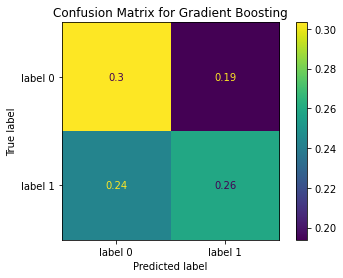

In [61]:
# Gradient boosting 
n_estimators = [1, 100, 300]
learning_rate = [0.1]
max_depth = [1]
max_score = 0
for n_i, lr_i, md_i in itertools.product(n_estimators, learning_rate, max_depth):
  gb_win_i = GradientBoostingClassifier(n_estimators=n_i, learning_rate=lr_i,
                                        max_depth=md_i, random_state=0)
  scores_i = cross_val_score(gb_win_i, X_train, y_train_win, cv=5)
  if np.mean(scores_i) > max_score:
    gb_win = gb_win_i
    max_score = np.mean(scores_i)
    pars = [n_i, lr_i, md_i]
print('Chosen number of estimators, learning rate, depth:', pars)
gb_win = gb_win.fit(X_train, y_train_win)
y_pred_gb_win = gb_win.predict(X_test).reshape(-1,1)
print('Train CV mean accuracy:', max_score)
print('Test accuracy:',accuracy_score(y_test_win, y_pred_gb_win))
plotConfusion(y_test_win, y_pred_gb_win, 'Gradient Boosting')